In [27]:
!pip install hnswlib polars  --quiet
!pip install shap gradio --quiet

In [28]:
# Suppress warnings
import re
import warnings

import gradio as gr
import hnswlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import shap
import xgboost as xgb
from scipy.spatial import distance
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Suppress warnings
warnings.filterwarnings("ignore")

In [29]:
# Use alternative encoding to avoid UnicodeDecodeError
df = pl.read_csv('../data/fy2022_archived_opportunities.csv', encoding='latin-1')

# Get the first 85000 rows
df = df.tail(5000)
df

NoticeId,Title,Sol#,Department/Ind.Agency,CGAC,Sub-Tier,FPDS Code,Office,AAC Code,PostedDate,Type,BaseType,ArchiveType,ArchiveDate,SetASideCode,SetASide,ResponseDeadLine,NaicsCode,ClassificationCode,PopStreetAddress,PopCity,PopState,PopZip,PopCountry,Active,AwardNumber,AwardDate,Award$,Awardee,PrimaryContactTitle,PrimaryContactFullname,PrimaryContactEmail,PrimaryContactPhone,PrimaryContactFax,SecondaryContactTitle,SecondaryContactFullname,SecondaryContactEmail,SecondaryContactPhone,SecondaryContactFax,OrganizationType,State,City,ZipCode,CountryCode,AdditionalInfoLink,Link,Description
str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""5e29df288d384a329df227446a287b…","""Fire Alarm Services for CJIS D…","""FAU-22-01-0002""","""JUSTICE, DEPARTMENT OF""",15,"""FEDERAL BUREAU OF INVESTIGATIO…","""1549""","""FBI-JEH""","""15F067""","""2021-10-07 16:02:17.295-04""","""Combined Synopsis/Solicitation""","""Combined Synopsis/Solicitation""","""auto15""","""2021-11-23""","""""","""""","""2021-11-08T15:00:00-05:00""","""561621""","""J012""","""""","""Clarksburg""","""WV""","""26306""","""USA""","""No""","""""","""""","""""","""""","""""","""Logan Swiger""","""lswiger2@fbi.gov""","""3046258133""","""""","""""","""Kaitlin B. Casey""","""kbcasey@fbi.gov""","""2027348954""","""""","""OFFICE""","""DC""","""WASHINGTON""","""20535""","""USA""","""""","""https://sam.gov/opp/5e29df288d…","""*THIS REQUIREMENT IS SUBJECT T…"
"""43483d0343364181b40e481a69c293…","""43--PARTS KIT,COMPRESSO""","""SPE7M122Q0003""","""DEPT OF DEFENSE""",97,"""DEFENSE LOGISTICS AGENCY (DLA)""","""97AS""","""DLA LAND AND MARITIME""","""SPE7M1""","""2021-10-07 16:02:16.56-04""","""Combined Synopsis/Solicitation""","""Combined Synopsis/Solicitation""","""autocustom""","""2021-11-21""","""HZC""","""Historically Underutilized Bus…","""2021-10-22""","""333912""","""43""","""""","""""","""""","""""","""""","""No""","""""","""""","""""","""""","""""","""Questions regarding this solic…","""DibbsBSM@dla.mil""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""OH""","""COLUMBUS""","""43218-3990""","""USA""","""""","""https://sam.gov/opp/43483d0343…","""Proposed procurement for NSN 4…"
"""d7be3af71470457c9ead2a0325d3eb…","""89--Original Buy# 1076868 FPC …","""15B10122Q00000005""","""JUSTICE, DEPARTMENT OF""",15,"""FEDERAL PRISON SYSTEM / BUREAU…","""1540""","""FPC ALDERSON""","""15B101""","""2021-10-07 16:02:04.499-04""","""Award Notice""","""Combined Synopsis/Solicitation""","""autocustom""","""2022-02-22""","""""","""""","""""","""""","""8945""","""""","""""","""""","""""","""""","""No""","""15B10121P00000459""","""2021-10-07""","""24064.74""","""A. F. WENDLING, INC. DBA WENDL…","""""","""Name: Marketplace Support, Tit…","""marketplacesupport@unisongloba…","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""WV""","""ALDERSON""","""24910""","""USA""","""""","""https://sam.gov/opp/d7be3af714…","""Award Notice"""
"""9e1df03899a74c42901322617745ad…","""PreExeval SCVS Exercise Suppor…","""W91243-22-Q-E001""","""DEPT OF DEFENSE""",21,"""DEPT OF THE ARMY""","""2100""","""W7NL USPFO ACTIVITY NE ARNG""","""W91243""","""2021-10-07 16:01:58.71-04""","""Combined Synopsis/Solicitation""","""Combined Synopsis/Solicitation""","""auto15""","""2021-10-28""","""SBA""","""Total Small Business Set-Aside…","""2021-10-13T10:00:00-05:00""","""611699""","""U099""","""""","""Yutan""","""NE""","""68073""","""USA""","""No""","""""","""""","""""","""""","""""","""Jarod Epp""","""jarod.w.epp.civ@mail.mil""","""4023098286""","""""","""""","""""","""""","""""","""""","""OFFICE""","""NE""","""LINCOLN""","""68524-1801""","""USA""","""""","""https://sam.gov/opp/9e1df03899…","""See Q&A Log along with an upda…"
"""54807620f38b4c50917b721087a9d7…","""C45 Rapid Prototype Developmen…","""RFPN6660418R1436_N6660420DK001""","""DEPT OF DEFENSE""",17,"""DEPT OF

In [30]:
# Function to clean column names
def clean_names(df):
    """
    Cleans column names of a Polars DataFrame by removing special characters,
    converting to lowercase, and replacing spaces with underscores.

    Args:
        df: Polars DataFrame

    Returns:
        Polars DataFrame with cleaned column names.
    """
    df.columns = [re.sub(r'\W+', '_', col).lower() for col in df.columns]
    return df

# Load your DataFrame
# df2023 = pl.read_csv('your_dataset.csv')  # Replace with your actual data loading method

# Clean column names
df2022 = clean_names(df)
df2022

noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,type,basetype,archivetype,archivedate,setasidecode,setaside,responsedeadline,naicscode,classificationcode,popstreetaddress,popcity,popstate,popzip,popcountry,active,awardnumber,awarddate,award_,awardee,primarycontacttitle,primarycontactfullname,primarycontactemail,primarycontactphone,primarycontactfax,secondarycontacttitle,secondarycontactfullname,secondarycontactemail,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""5e29df288d384a329df227446a287b…","""Fire Alarm Services for CJIS D…","""FAU-22-01-0002""","""JUSTICE, DEPARTMENT OF""",15,"""FEDERAL BUREAU OF INVESTIGATIO…","""1549""","""FBI-JEH""","""15F067""","""2021-10-07 16:02:17.295-04""","""Combined Synopsis/Solicitation""","""Combined Synopsis/Solicitation""","""auto15""","""2021-11-23""","""""","""""","""2021-11-08T15:00:00-05:00""","""561621""","""J012""","""""","""Clarksburg""","""WV""","""26306""","""USA""","""No""","""""","""""","""""","""""","""""","""Logan Swiger""","""lswiger2@fbi.gov""","""3046258133""","""""","""""","""Kaitlin B. Casey""","""kbcasey@fbi.gov""","""2027348954""","""""","""OFFICE""","""DC""","""WASHINGTON""","""20535""","""USA""","""""","""https://sam.gov/opp/5e29df288d…","""*THIS REQUIREMENT IS SUBJECT T…"
"""43483d0343364181b40e481a69c293…","""43--PARTS KIT,COMPRESSO""","""SPE7M122Q0003""","""DEPT OF DEFENSE""",97,"""DEFENSE LOGISTICS AGENCY (DLA)""","""97AS""","""DLA LAND AND MARITIME""","""SPE7M1""","""2021-10-07 16:02:16.56-04""","""Combined Synopsis/Solicitation""","""Combined Synopsis/Solicitation""","""autocustom""","""2021-11-21""","""HZC""","""Historically Underutilized Bus…","""2021-10-22""","""333912""","""43""","""""","""""","""""","""""","""""","""No""","""""","""""","""""","""""","""""","""Questions regarding this solic…","""DibbsBSM@dla.mil""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""OH""","""COLUMBUS""","""43218-3990""","""USA""","""""","""https://sam.gov/opp/43483d0343…","""Proposed procurement for NSN 4…"
"""d7be3af71470457c9ead2a0325d3eb…","""89--Original Buy# 1076868 FPC …","""15B10122Q00000005""","""JUSTICE, DEPARTMENT OF""",15,"""FEDERAL PRISON SYSTEM / BUREAU…","""1540""","""FPC ALDERSON""","""15B101""","""2021-10-07 16:02:04.499-04""","""Award Notice""","""Combined Synopsis/Solicitation""","""autocustom""","""2022-02-22""","""""","""""","""""","""""","""8945""","""""","""""","""""","""""","""""","""No""","""15B10121P00000459""","""2021-10-07""","""24064.74""","""A. F. WENDLING, INC. DBA WENDL…","""""","""Name: Marketplace Support, Tit…","""marketplacesupport@unisongloba…","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""WV""","""ALDERSON""","""24910""","""USA""","""""","""https://sam.gov/opp/d7be3af714…","""Award Notice"""
"""9e1df03899a74c42901322617745ad…","""PreExeval SCVS Exercise Suppor…","""W91243-22-Q-E001""","""DEPT OF DEFENSE""",21,"""DEPT OF THE ARMY""","""2100""","""W7NL USPFO ACTIVITY NE ARNG""","""W91243""","""2021-10-07 16:01:58.71-04""","""Combined Synopsis/Solicitation""","""Combined Synopsis/Solicitation""","""auto15""","""2021-10-28""","""SBA""","""Total Small Business Set-Aside…","""2021-10-13T10:00:00-05:00""","""611699""","""U099""","""""","""Yutan""","""NE""","""68073""","""USA""","""No""","""""","""""","""""","""""","""""","""Jarod Epp""","""jarod.w.epp.civ@mail.mil""","""4023098286""","""""","""""","""""","""""","""""","""""","""OFFICE""","""NE""","""LINCOLN""","""68524-1801""","""USA""","""""","""https://sam.gov/opp/9e1df03899…","""See Q&A Log along with an upda…"
"""54807620f38b4c50917b721087a9d7…","""C45 Rapid Prototype Developmen…","""RFPN6660418R1436_N6660420DK001""","""DEPT OF DEFENSE""",17,"""DEPT OF

In [31]:
# Calculate the number of unique values and missing values for each column
summary = pl.DataFrame({
    'column': df2022.columns,
    'unique_values': [df2022[col].n_unique() for col in df2022.columns],
    'missing_values': [df2022[col].null_count() for col in df2022.columns]
})

# Display the summary
print(summary)

shape: (47, 3)
┌───────────────────────┬───────────────┬────────────────┐
│ column                ┆ unique_values ┆ missing_values │
│ ---                   ┆ ---           ┆ ---            │
│ str                   ┆ i64           ┆ i64            │
╞═══════════════════════╪═══════════════╪════════════════╡
│ noticeid              ┆ 5000          ┆ 0              │
│ title                 ┆ 3709          ┆ 0              │
│ sol_                  ┆ 4359          ┆ 0              │
│ department_ind_agency ┆ 40            ┆ 0              │
│ cgac                  ┆ 41            ┆ 0              │
│ …                     ┆ …             ┆ …              │
│ zipcode               ┆ 524           ┆ 0              │
│ countrycode           ┆ 11            ┆ 0              │
│ additionalinfolink    ┆ 1             ┆ 0              │
│ link                  ┆ 5000          ┆ 0              │
│ description           ┆ 3734          ┆ 0              │
└───────────────────────┴───────────────┴

In [32]:
# List of categorical columns
categorical_cols = ['title', 'sol_', 'department_ind_agency', 'sub_tier', 'fpds_code', 'office',
                     'aac_code', 'posteddate', 'type', 'basetype', 'archivetype', 'archivedate', 
                     'setasidecode', 'setaside', 'responsedeadline', 'naicscode', 'classificationcode', 
                     'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry', 'awardnumber',
                     'awarddate', 'awardee', 'state', 'city', 'zipcode', 'countrycode', 'description']

# Convert all categorical columns to strings
df2022 = df2022.with_columns([pl.col(col).cast(pl.Utf8) for col in categorical_cols])

In [33]:
# Apply LabelEncoder to each categorical column
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df2022 = df2022.with_columns([pl.Series(col, le.fit_transform(df2022[col].to_list()))])
    label_encoders[col] = le

# Ensure numerical columns are in the correct format

df2022

noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,type,basetype,archivetype,archivedate,setasidecode,setaside,responsedeadline,naicscode,classificationcode,popstreetaddress,popcity,popstate,popzip,popcountry,active,awardnumber,awarddate,award_,awardee,primarycontacttitle,primarycontactfullname,primarycontactemail,primarycontactphone,primarycontactfax,secondarycontacttitle,secondarycontactfullname,secondarycontactemail,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,i64
"""5e29df288d384a329df227446a287b…",2087,1312,20,15,39,26,248,91,4976,1,1,0,74,0,0,728,377,460,0,117,54,208,42,"""No""",0,0,"""""",0,"""""","""Logan Swiger""","""lswiger2@fbi.gov""","""3046258133""","""""","""""","""Kaitlin B. Casey""","""kbcasey@fbi.gov""","""2027348954""","""""","""OFFICE""",11,312,113,8,"""""","""https://sam.gov/opp/5e29df288d…",47
"""43483d0343364181b40e481a69c293…",627,3284,7,97,22,95,133,526,4975,1,1,2,72,4,4,512,166,133,0,0,0,0,0,"""No""",0,0,"""""",0,"""""","""Questions regarding this solic…","""DibbsBSM@dla.mil""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""",39,68,285,8,"""""","""https://sam.gov/opp/43483d0343…",1758
"""d7be3af71470457c9ead2a0325d3eb…",1370,185,20,15,47,23,269,72,4974,0,1,2,149,0,0,0,0,327,0,0,0,0,0,"""No""",102,109,"""24064.74""",5,"""""","""Name: Marketplace Support, Tit…","""marketplacesupport@unisongloba…","""""","""""","""""","""""","""""","""""","""""","""OFFICE""",54,8,201,8,"""""","""https://sam.gov/opp/d7be3af714…",284
"""9e1df03899a74c42901322617745ad…",2874,4146,7,21,28,41,608,618,4973,1,1,0,48,6,9,287,398,600,0,566,32,446,42,"""No""",0,0,"""""",0,"""""","""Jarod Epp""","""jarod.w.epp.civ@mail.mil""","""4023098286""","""""","""""","""""","""""","""""","""""","""OFFICE""",33,179,356,8,"""""","""https://sam.gov/opp/9e1df03899…",2593
"""54807620f38b4c50917b721087a9d7…",1658,2148,7,17,29,32,388,481,4972,0,0,2,28,0,0,0,342,364,0,377,43,23,42,"""No""",783,9,"""46867283.00""",105,"""""","""Kaitlin L. Simoes""","""kaitlin.simoes@navy.mil""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""",44,225,15,8,"""""","""https://sam.gov/opp/54807620f3…",0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""9f5c5ffbcf544822897d81adf4d48a…",2485,1914,7,17,29,32,346,461,4,5,6,0,47,0,0,249,331,618,0,0,0,0,24,"""No""",0,0,"""""",0,"""""","""Ayako Yonashiro""","""Ayako.Yonashiro.JA@fe.navy.mil""","""0989700350""","""""","""""","""Kimberly Groce""","""Kimberly.Groce@fe.navy.mil""","""0989704153""","""""","""OFFICE""",5,119,487,8,"""""","""https://sam.gov/opp/9f5c5ffbcf…",2888
"""2e2ab5512120475dba81379f508400…",3099,4099,7,21,28,41,21,688,3,1,1,0,53,0,0,415,33,716,0,5,0,625,26,"""No""",0,0,"""""",0,"""""","""Raul Medina""","""raul.medina45.mil@mail.mil""","""05033635684""","""""","""""","""""","""""","""""","""""","""OFFICE""",5,17,484,8,"""""","""https://sam.gov/opp/2e2ab55121…",2448
"""bb24f68bc7e542c7bf1301c44fd0b1…",2623,1186,7,57,27,51,175,328,2,2,2,1,51,0,0,0,377,486,0,338,19,444,42,"""No""",478,98,"""""",0,"""""","""MSgt Brandon M. Williams""","""brandon.williams.6@us.af.mil""","""3167594520""","""""","""""","""""","""""","""""","""""","""OFFICE""",20,196,354,8,"""""","""https://sam.gov/opp/bb24f68bc7…",2844


In [34]:
# Separate numeric and non-numeric columns
numeric_cols = df2022.select(pl.col(pl.Float64) | pl.col(pl.Int64)).columns
non_numeric_cols = df2022.select(pl.col(pl.Utf8)).columns
non_numeric_cols

['noticeid',
 'active',
 'award_',
 'primarycontacttitle',
 'primarycontactfullname',
 'primarycontactemail',
 'primarycontactphone',
 'primarycontactfax',
 'secondarycontacttitle',
 'secondarycontactfullname',
 'secondarycontactemail',
 'secondarycontactphone',
 'secondarycontactfax',
 'organizationtype',
 'additionalinfolink',
 'link']

In [35]:
# Impute missing values for numeric columns
imputer = SimpleImputer(strategy='mean')
imputer

SimpleImputer()

In [36]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df2022_df):
    # Filter rows based on column: 'award_'
    df2022_df = df2022_df[(df2022_df['award_'].notna()) & (df2022_df['award_'] != "")]
    return df2022_df

# Loaded variable 'df2022' from kernel state
df2022_df = df2022.to_pandas()

df2022_df_clean = clean_data(df2022_df.copy())
df2022_df_clean.head()

,noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,...,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
2,d7be3af71470457c9ead2a0325d3ebba,1370,185,20,15,47,23,269,72,4974,...,,,OFFICE,54,8,201,8,,https://sam.gov/opp/d7be3af71470457c9ead2a0325...,284
4,54807620f38b4c50917b721087a9d73a,1658,2148,7,17,29,32,388,481,4972,...,,,OFFICE,44,225,15,8,,https://sam.gov/opp/54807620f38b4c50917b721087...,0
5,2209e9d6faf64a6e866d196f7ad691f0,2991,374,39,36,100,47,433,137,4971,...,,,OFFICE,24,120,157,8,,https://sam.gov/opp/2209e9d6faf64a6e866d196f7a...,2640
10,84eb571c82ac4471992025923e3deda9,1758,941,15,75,63,74,328,264,4966,...,,,OFFICE,24,39,143,8,,https://sam.gov/opp/84eb571c82ac4471992025923e...,0
16,5bda6d0c72254ff99d7b1067c50ba141,1758,941,15,75,63,74,328,264,4960,...,,,OFFICE,24,39,143,8,,https://sam.gov/opp/5bda6d0c72254ff99d7b1067c5...,0


In [37]:
df2022_df_clean.columns

Index(['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac',
       'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type',
       'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'award_', 'awardee',
       'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail',
       'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

In [38]:
# Define features and target
X = df2022_df_clean.drop('award_', axis=1)
y = df2022_df_clean['award_']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
print(X_train)

                              noticeid  title  sol_  department_ind_agency  \
1111  4654ac7bc7904746884023e8e59a38d6   1609  2349                      7   
4773  c06c8e7a824b4144a6e1a7fe679ba106    326  2897                      7   
2700  26e306fed2804da59c3079051990e495   3481    32                      2   
3805  060cae334b04428989729e04332bf67e   2995  1159                      7   
2284  7128c27f510a4e85a4c882dd2604f72d   1502  2096                     15   
...                                ...    ...   ...                    ...   
4273  fb31b28632024e8699e632319e1d3dd4   2652  2032                      7   
4339  063b4414924e4dcbab4160db43ec8eb6   3145   755                     39   
4666  988466a544864b328f89440692734779   1837   347                     39   
3485  8a34a1a5afd64b9ebe0d52183795b5d0    740  3393                      7   
4331  c3de0fb7914a43b7995eb62f32829585   1357  2189                      7   

      cgac  sub_tier  fpds_code  office  aac_code  posteddate  

In [40]:
print(X_test)

                              noticeid  title  sol_  department_ind_agency  \
2211  599d6ce0f94c4beb990e2b63b9f124a6   2532  1467                      7   
4621  bfc138f2fc814addaebd1defcb146cd9    444  3173                      7   
1737  8a7c913cac1e486fa7ec62d7ef99cf6f    392  3095                      7   
4007  2536e2a5a11544b98eac7affc101c11a   1890  4212                      7   
3977  59819a14716d4eaa9732781184277f88   1511  4218                      7   
...                                ...    ...   ...                    ...   
1947  0d2dcf4df3204b0eb213d461bf6e1fa3   2053   119                      4   
2809  e1a6c3fc673d4853a8bc4b5e73af90f9    851  2884                      7   
4674  db766600c275478a92bed09930d0793e   1845   343                     39   
2732  c089e51325e14d2e87e251e167649f6b   3413  1253                      7   
2877  986ccf9560474c31b11e9d0c26d18de9     21  2801                      7   

      cgac  sub_tier  fpds_code  office  aac_code  posteddate  

In [41]:
print(y_train)

1111           250000.00
4773            30289.99
2700          5000000.00
3805           119435.35
2284            31811.40
              ...       
4273            59568577
4339           319798.00
4666    3222201.53000000
3485           250000.00
4331            36271.75
Name: award_, Length: 1165, dtype: object


In [42]:
print(y_test)

2211           395817.30
4621            34824.40
1737            59341.88
4007            74854.57
3977           102012.00
              ...       
1947          4880702.45
2809            38584.00
4674    2824099.35000000
2732          6626157.84
2877            29239.50
Name: award_, Length: 292, dtype: object


In [43]:
# Function to clean currency columns
def clean_currency_columns(df):
    currency_cols = df.columns[df.apply(lambda col: col.astype(str).str.contains(r'\$').any())]
    for col in currency_cols:
        df[col] = df[col].str.replace('[\$,]', '', regex=True).astype(float)
    return df

# Clean X_train and X_test
X_train = clean_currency_columns(X_train)
X_test = clean_currency_columns(X_test)

In [44]:
# Train XGBoost model with enable_categorical=True
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42,
    enable_categorical=True
)

In [45]:
X_train.columns

Index(['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac',
       'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type',
       'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'awardee', 'primarycontacttitle',
       'primarycontactfullname', 'primarycontactemail', 'primarycontactphone',
       'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

In [46]:
# Extract the first letter of each column name
first_letters = pd.Series(X_train.columns).str[0].str.lower()

# Count the number of variables by the first letter
first_letter_counts = first_letters.value_counts().reset_index()
first_letter_counts.columns = ['first_letter', 'count']

# Display the counts
print(first_letter_counts)

   first_letter  count
0             p     11
1             s     10
2             a      8
3             c      4
4             n      2
5             t      2
6             d      2
7             o      2
8             f      1
9             b      1
10            r      1
11            z      1
12            l      1


In [47]:
# Find columns starting with 'aw'
a_columns = [col for col in X_train.columns ]
print("Columns starting with 'a':", a_columns)

# Display the first few rows of X_train
print(X_train[a_columns])

Columns starting with 'a': ['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac', 'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type', 'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside', 'responsedeadline', 'naicscode', 'classificationcode', 'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry', 'active', 'awardnumber', 'awarddate', 'awardee', 'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail', 'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle', 'secondarycontactfullname', 'secondarycontactemail', 'secondarycontactphone', 'secondarycontactfax', 'organizationtype', 'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link', 'description']
                              noticeid  title  sol_  department_ind_agency  \
1111  4654ac7bc7904746884023e8e59a38d6   1609  2349                      7   
4773  c06c8e7a824b4144a6e1a7fe679ba106    326  2897                      7   
2700  26e306fed2

In [48]:
X_train=X_train[a_columns]
X_test=X_test[a_columns]

In [49]:
# Remove the specified columns
X_train = X_train.drop(columns=['noticeid', 'additionalinfolink', 'link'])
X_test = X_test.drop(columns=['noticeid', 'additionalinfolink', 'link'])

# Display the updated dataframes
print(X_train.head())
print(X_test.head())

      title  sol_  department_ind_agency  cgac  sub_tier  fpds_code  office  \
1111   1609  2349                      7    97        22         95     121   
4773    326  2897                      7    97        22         95     133   
2700   3481    32                      2    12        49          4     504   
3805   2995  1159                      7    57        27         51     161   
2284   1502  2096                     15    75        63         74     330   

      aac_code  posteddate  type  ...    secondarycontactfullname  \
1111       507        3869     0  ...  QUINESHA CRUZ 804-279-4674   
4773       520         222     0  ...                               
2700        11        2289     0  ...            Dana Price, CFCM   
3805       314        1189     0  ...                 Gary Wynder   
2284       266        2700     0  ...                               

      secondarycontactemail  secondarycontactphone  secondarycontactfax  \
1111  QUINESHA.CRUZ@DLA.MIL        

In [50]:
# Remove '$' and ',' then convert to float
#y_train = y_train.str.replace(r'[\$,]', '', regex=True).astype(float)
y_test = y_test.str.replace(r'[\$,]', '', regex=True).astype(float)

In [51]:
# Check the number of columns
print("Number of columns in X_train:", X_train.shape[1])
print("Number of columns in X_test:", X_test.shape[1])

Number of columns in X_train: 43
Number of columns in X_test: 43


In [52]:
# Identify object columns
object_columns = X_train.select_dtypes(include=['object']).columns

# Clean columns containing '$'
for col in object_columns:
    if X_train[col].astype(str).str.contains('\$').any():
        X_train[col] = X_train[col].str.replace(r'[\$,]', '', regex=True).astype(float)
        X_test[col] = X_test[col].str.replace(r'[\$,]', '', regex=True).astype(float)

# Drop non-numeric columns without '$'
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test[X_train.columns]

# Ensure X_train and X_test have the same columns
X_test = X_test[X_train.columns]

# Fit the XGBoost model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-rmse:32731663.59184
[1]	validation_0-rmse:29681433.43638
[2]	validation_0-rmse:27105202.55856
[3]	validation_0-rmse:25070652.60837
[4]	validation_0-rmse:24576893.33305
[5]	validation_0-rmse:24086436.48199
[6]	validation_0-rmse:24390721.98014
[7]	validation_0-rmse:24431174.58056
[8]	validation_0-rmse:25030194.43968
[9]	validation_0-rmse:24779135.03878
[10]	validation_0-rmse:24829528.53477
[11]	validation_0-rmse:25002386.96745
[12]	validation_0-rmse:24989533.84866
[13]	validation_0-rmse:26001003.40968
[14]	validation_0-rmse:26028353.85045
[15]	validation_0-rmse:26700402.75128
[16]	validation_0-rmse:26603505.54728
[17]	validation_0-rmse:26886865.02242
[18]	validation_0-rmse:26916774.06186
[19]	validation_0-rmse:26888410.55099
[20]	validation_0-rmse:27381842.13798
[21]	validation_0-rmse:27821134.13509
[22]	validation_0-rmse:27827472.06664
[23]	validation_0-rmse:27759578.48427
[24]	validation_0-rmse:27722845.02370
[25]	validation_0-rmse:27716144.22397
[26]	validation_0-rmse

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [53]:
# Fit the XGBoost model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-rmse:32731663.59184
[1]	validation_0-rmse:29681433.43638
[2]	validation_0-rmse:27105202.55856
[3]	validation_0-rmse:25070652.60837
[4]	validation_0-rmse:24576893.33305
[5]	validation_0-rmse:24086436.48199
[6]	validation_0-rmse:24390721.98014
[7]	validation_0-rmse:24431174.58056
[8]	validation_0-rmse:25030194.43968
[9]	validation_0-rmse:24779135.03878
[10]	validation_0-rmse:24829528.53477
[11]	validation_0-rmse:25002386.96745
[12]	validation_0-rmse:24989533.84866
[13]	validation_0-rmse:26001003.40968
[14]	validation_0-rmse:26028353.85045
[15]	validation_0-rmse:26700402.75128
[16]	validation_0-rmse:26603505.54728
[17]	validation_0-rmse:26886865.02242
[18]	validation_0-rmse:26916774.06186
[19]	validation_0-rmse:26888410.55099
[20]	validation_0-rmse:27381842.13798
[21]	validation_0-rmse:27821134.13509
[22]	validation_0-rmse:27827472.06664
[23]	validation_0-rmse:27759578.48427
[24]	validation_0-rmse:27722845.02370
[25]	validation_0-rmse:27716144.22397
[26]	validation_0-rmse

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [54]:
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

XGBoost MSE: 804182341605497.0, R2: 0.41137991566670706


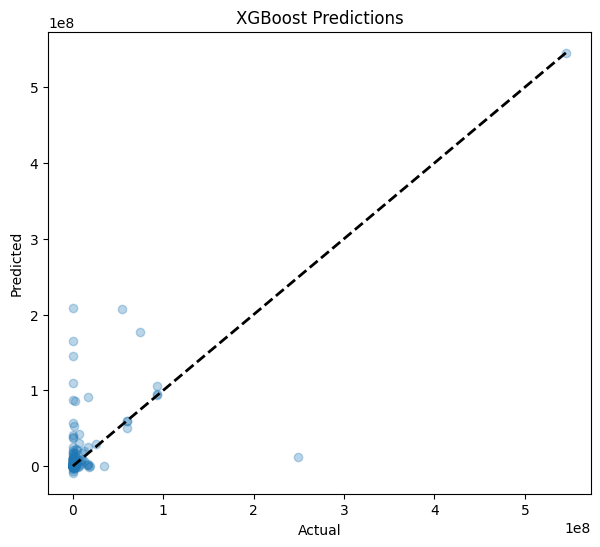

In [55]:
print(f"XGBoost MSE: {xgb_mse}, R2: {xgb_r2}")

# Plot the results
plt.figure(figsize=(7, 6))
plt.scatter(y_test, xgb_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBoost Predictions')
plt.show()

In [56]:
def clean_column_names(df):
    # Replace spaces and slashes with underscores
    df.columns = [col.replace(' ', '_').replace('/', '_') for col in df.columns]
    # Convert to lowercase
    df.columns = [col.lower() for col in df.columns]
    return df

# Assuming df2023 is your DataFrame
df2023 = clean_column_names(df)

In [57]:
# Define prediction function to match provided columns
def predict_popularity(title, department_agency, cgac, sub_tier, fpds_code, office, aac_code, 
                       posted_date, contract_type, base_type, archive_type, darchive_date, 
                       set_aside_code, set_aside, response_deadline, naics_code, 
                       classification_code, pop_street_address, pop_city, pop_state,
                       pop_zip, pop_country, award_number, award_date, award_amount,
                       awardee, primary_contact_title, primary_contact_fullname,
                       primary_contact_email, primary_contact_phone, primary_contact_fax, 
                       secondary_contact_title, secondary_contact_fullname, secondary_contact_email, 
                       secondary_contact_phone, secondary_contact_fax, organization_type, state, 
                       city, zip_code, country_code, additional_info_link, link, description):

    # Hash specific text fields to match the model's expected input format
    title_hashed = hash(str(title)) % 10**8
    department_agency_hashed = hash(str(department_agency)) % 10**8
    sub_tier_hashed = hash(str(sub_tier)) % 10**8
    awardee_hashed = hash(str(awardee)) % 10**8

    # Create a DataFrame for the input, matching the column names in X
    input_data = pd.DataFrame([[
        title_hashed, department_agency_hashed, cgac, sub_tier_hashed, fpds_code,
        office, aac_code, posted_date, contract_type, base_type, archive_type,
        set_aside_code, set_aside, response_deadline, naics_code, classification_code,
        pop_street_address, pop_city, pop_state, pop_zip, pop_country,
        award_number, award_date, award_amount, awardee_hashed, primary_contact_title,
        primary_contact_fullname, primary_contact_email, primary_contact_phone,
        primary_contact_fax, secondary_contact_title, secondary_contact_fullname,
        secondary_contact_email, secondary_contact_phone, secondary_contact_fax,
        organization_type, state, city, zip_code, country_code, additional_info_link,
        link, description
    ]], columns=X.columns)

    # Define numeric columns, if any, to normalize
    # (Assume 'award_amount' as a numerical example, modify as needed based on your data)
    numerical_cols = ['award_amount']
    input_data[numerical_cols] = (input_data[numerical_cols] - X[numerical_cols].mean()) / X[numerical_cols].std()

    # Return the DataFrame ready for prediction
    return input_data


In [58]:
X_train.dtypes.to_frame('Data Type')

,Data Type
title,int64
sol_,int64
department_ind_agency,int64
cgac,int64
sub_tier,int64
fpds_code,int64
office,int64
aac_code,int64
posteddate,int64
type,int64


In [59]:
# Missing values in each row
missing_values_per_row = X_train.isnull().sum(axis=1)
count_per_missing_value = missing_values_per_row.value_counts().sort_index()

# Print the results
for missing, rows in count_per_missing_value.items():
    print(f'{rows} row(s) have {missing} missing values')

total_rows_with_missing_values = (X_train.isnull().any(axis=1)).sum()
print(f'Total number of rows with missing values: {total_rows_with_missing_values}')

1165 row(s) have 0 missing values
Total number of rows with missing values: 0


In [60]:
dist_numerical_cols = X_train.describe().T[['min', 'max']]
dist_numerical_cols['Missing Values'] = X_train.isnull().sum()
dist_numerical_cols['Missing Percentage'] = (X_train.isnull().mean() * 100).round(2)

The output shows that all numeric columns have a missing value percentage of 0, indicating that **there are no missing values** in these columns.

To gain further insights into the data, we used the `describe()` method to generate a comprehensive statistical summary of the numerical columns.

**👉 Distribution of numerical columns**

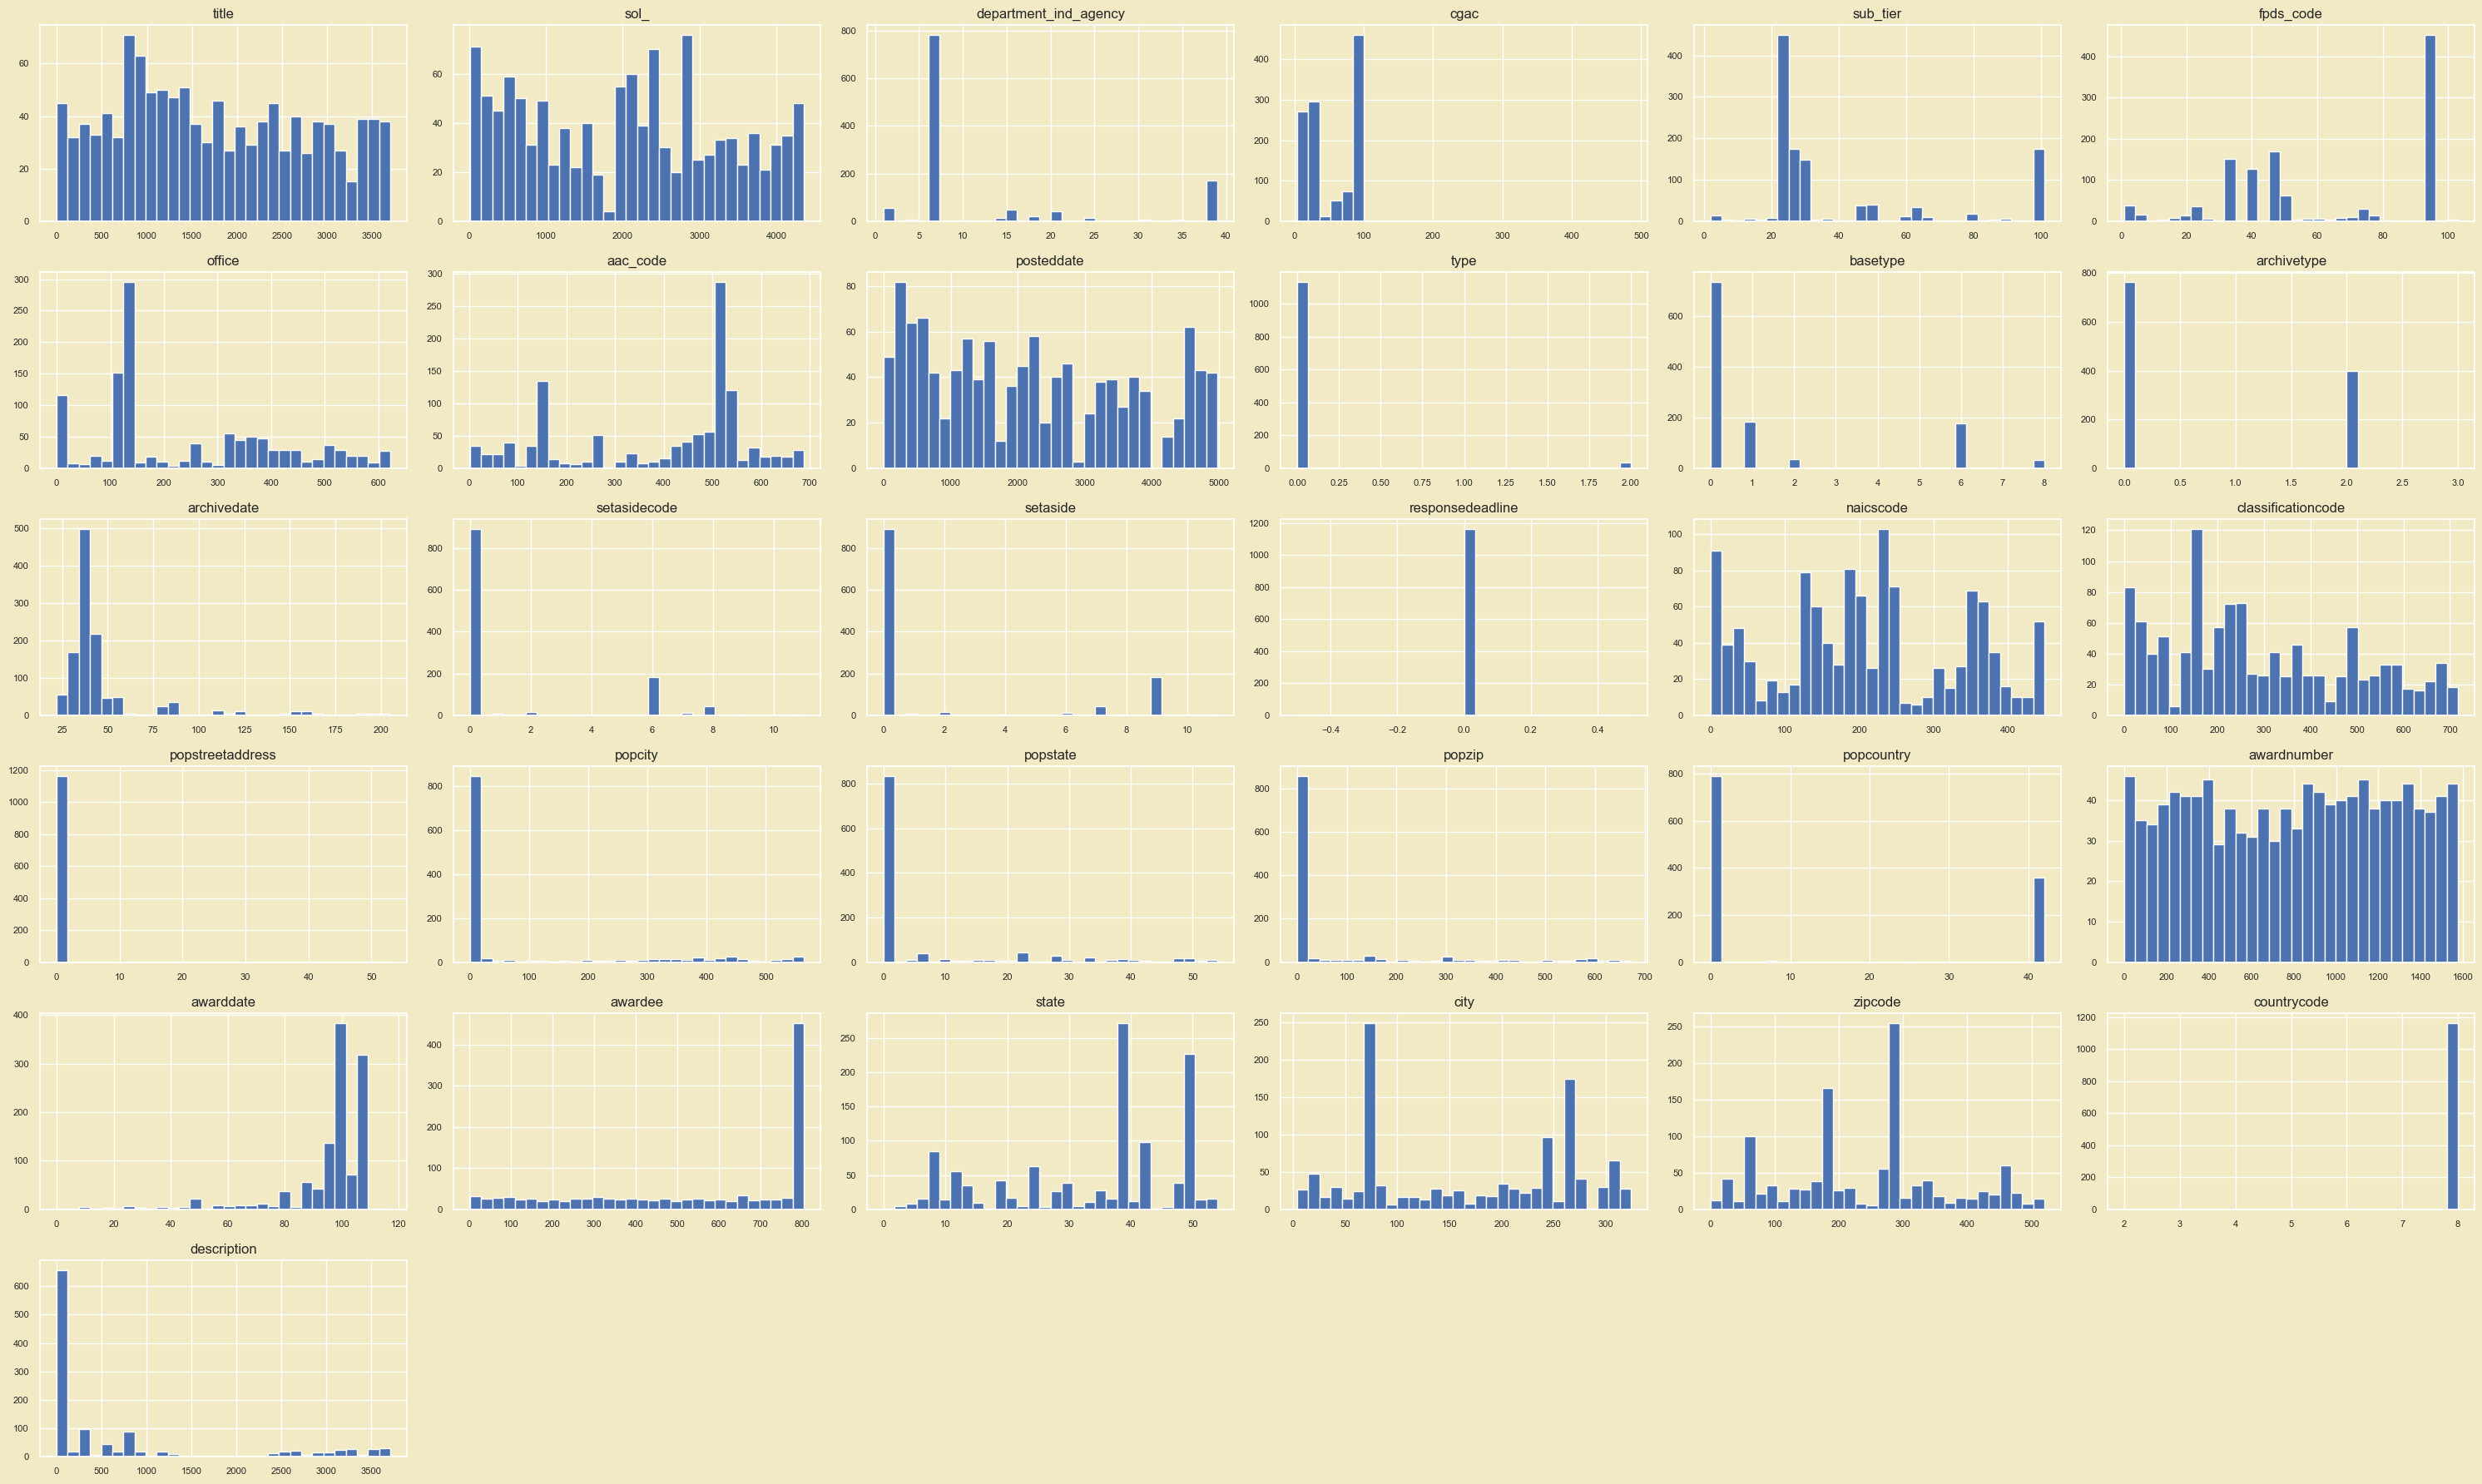

In [61]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
X_train.hist(figsize=(30,18), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

<Figure size 3200x1500 with 0 Axes>

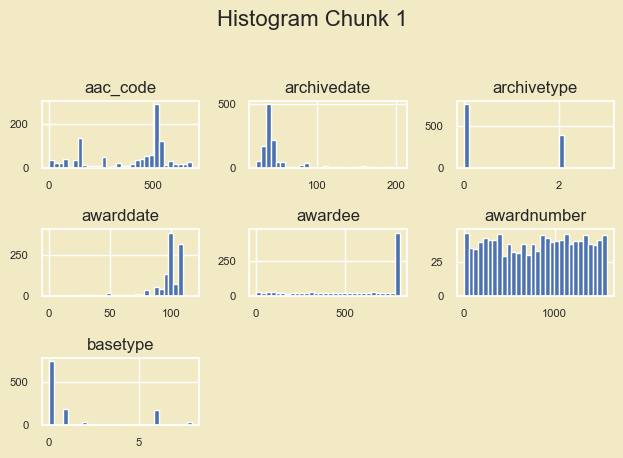

<Figure size 3200x1500 with 0 Axes>

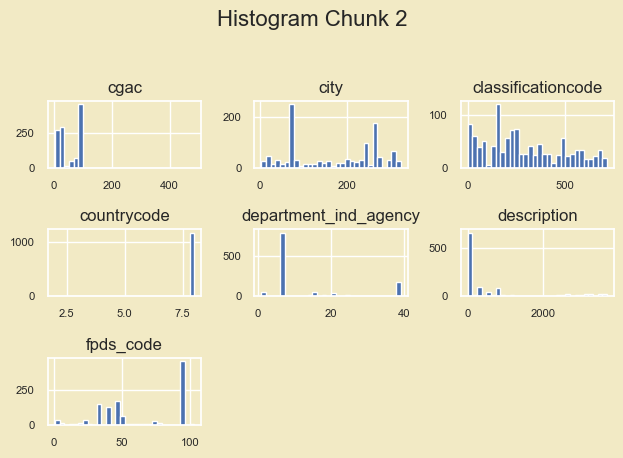

<Figure size 3200x1500 with 0 Axes>

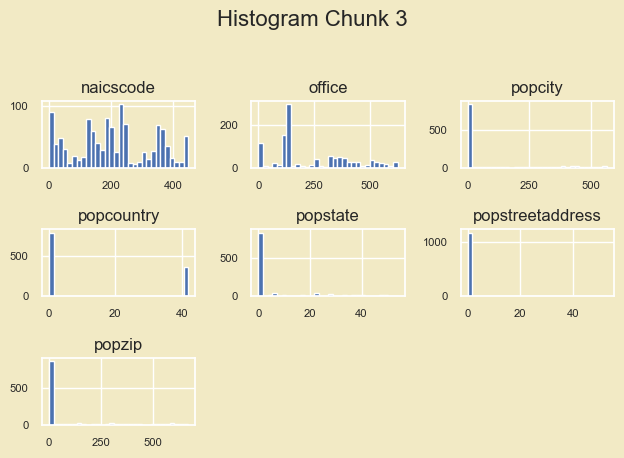

<Figure size 3200x1500 with 0 Axes>

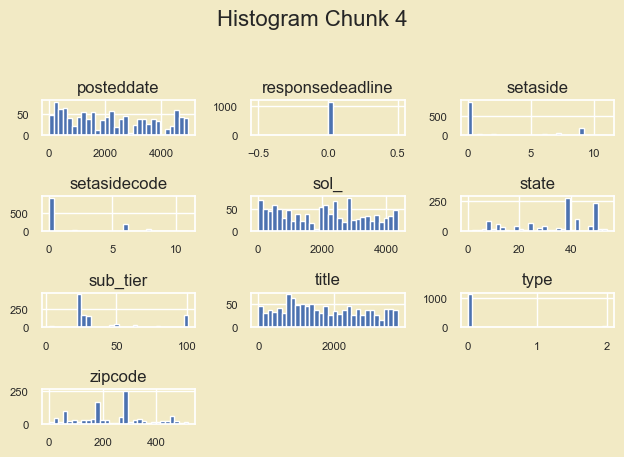

In [62]:
# Set Seaborn style
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor": "#F2EAC5", "figure.facecolor": "#F2EAC5"})

# Sort the columns by name
sorted_columns = sorted(X_train.columns)

# Split columns into four roughly equal parts
num_chunks = 4
chunk_size = len(sorted_columns) // num_chunks
chunks = [sorted_columns[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]

# If there are remaining columns, add them to the last chunk
if len(sorted_columns) % num_chunks != 0:
    chunks[-1].extend(sorted_columns[num_chunks * chunk_size:])

# Plot histograms for each chunk
for idx, chunk in enumerate(chunks, 1):
    plt.figure(figsize=(32, 15))
    X_train[chunk].hist(bins=30, xlabelsize=8, ylabelsize=8)
    plt.suptitle(f'Histogram Chunk {idx}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [63]:
unique_values = X_train.nunique()
missing_values = X_train.isnull().sum()

summary = pd.DataFrame({
    'Unique Values': unique_values,
    'Missing Values': missing_values
})

In [64]:
summary_sorted = summary.sort_values(by='Unique Values', ascending=True)

print(summary_sorted)

                       Unique Values  Missing Values
responsedeadline                   1               0
popstreetaddress                   2               0
countrycode                        2               0
type                               2               0
archivetype                        3               0
basetype                           6               0
popcountry                         9               0
setasidecode                      10               0
setaside                          10               0
department_ind_agency             21               0
cgac                              23               0
state                             47               0
popstate                          49               0
sub_tier                          52               0
fpds_code                         52               0
archivedate                       72               0
awarddate                         89               0
city                             167          

In [65]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1165 entries, 1111 to 4331
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   title                  1165 non-null   int64
 1   sol_                   1165 non-null   int64
 2   department_ind_agency  1165 non-null   int64
 3   cgac                   1165 non-null   int64
 4   sub_tier               1165 non-null   int64
 5   fpds_code              1165 non-null   int64
 6   office                 1165 non-null   int64
 7   aac_code               1165 non-null   int64
 8   posteddate             1165 non-null   int64
 9   type                   1165 non-null   int64
 10  basetype               1165 non-null   int64
 11  archivetype            1165 non-null   int64
 12  archivedate            1165 non-null   int64
 13  setasidecode           1165 non-null   int64
 14  setaside               1165 non-null   int64
 15  responsedeadline       1165 non-null   i

In [66]:
# Import necessary libraries
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
# Fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Fit Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

# Evaluate the models
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print(f"Random Forest MSE: {rf_mse}, R2: {rf_r2}")
print(f"Ridge Regression MSE: {ridge_mse}, R2: {ridge_r2}")

Random Forest MSE: 5424049718175849.0, R2: -2.970125228274247
Ridge Regression MSE: 2411162711426785.0, R2: -0.7648470068465678


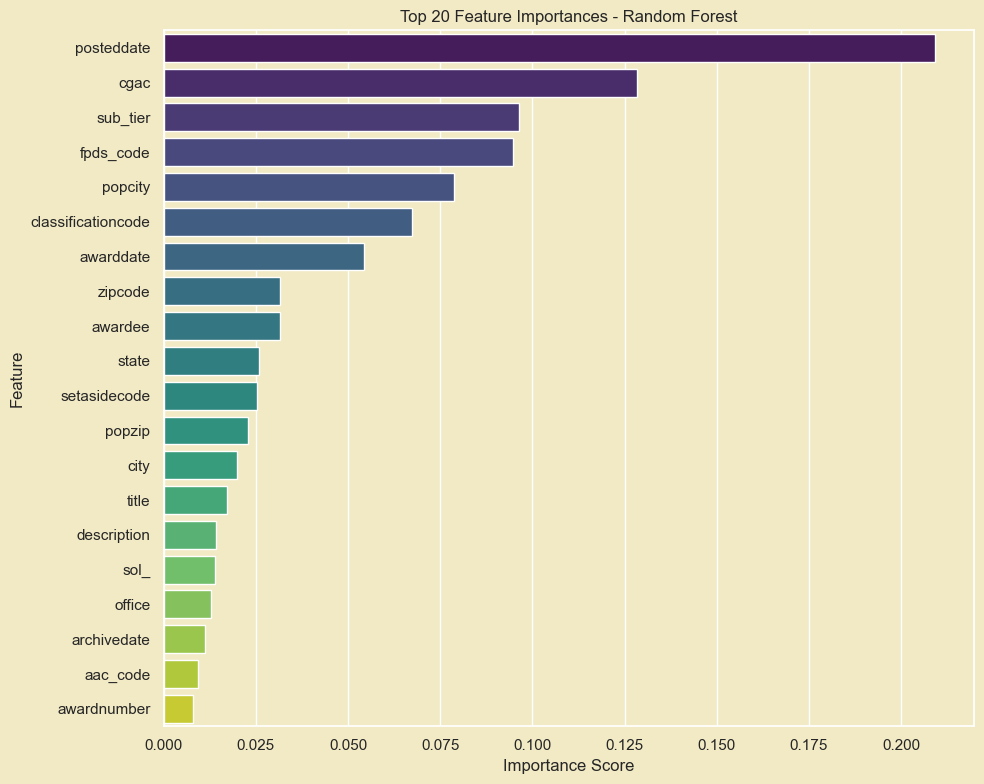

In [68]:
# Set Seaborn style
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor": "#F2EAC5", "figure.facecolor": "#F2EAC5"})

# 1. Feature Importance for Random Forest
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)  # Top 20 features

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Top 20 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

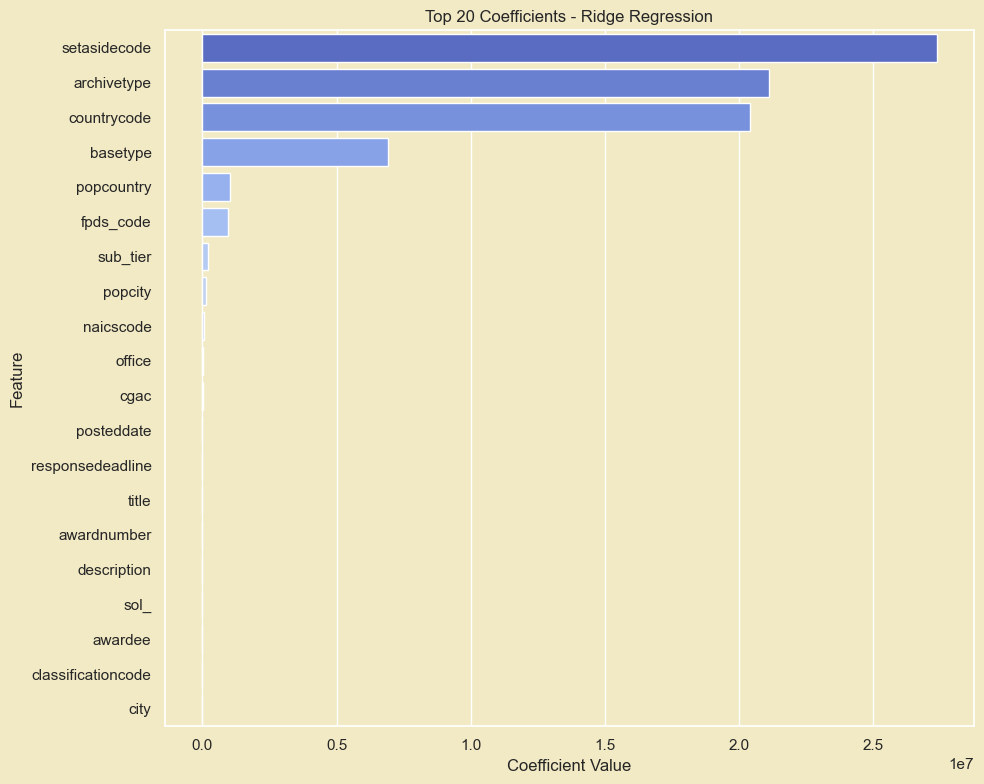

In [69]:
# 2. Coefficient Analysis for Ridge Regression
coefficients = ridge_model.coef_
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False).head(20)  # Top 20 positive coefficients

plt.figure(figsize=(10, 8))
sns.barplot(x='coefficient', y='feature', data=coef_df, palette='coolwarm')
plt.title('Top 20 Coefficients - Ridge Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

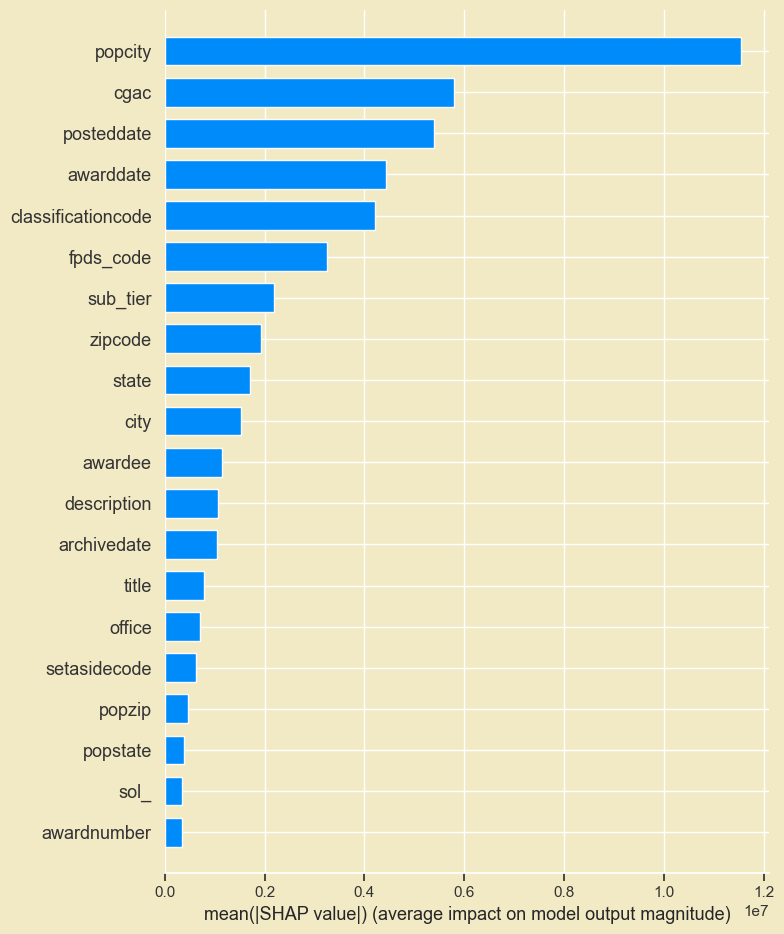

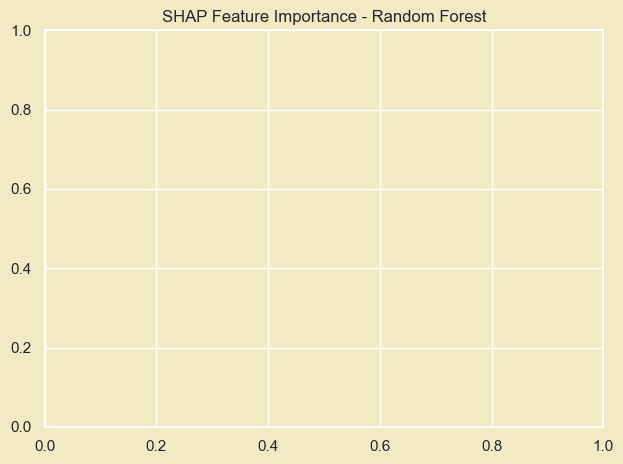

In [70]:
# 3. SHAP Values for Model Explainability
# Random Forest SHAP
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")
plt.title('SHAP Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

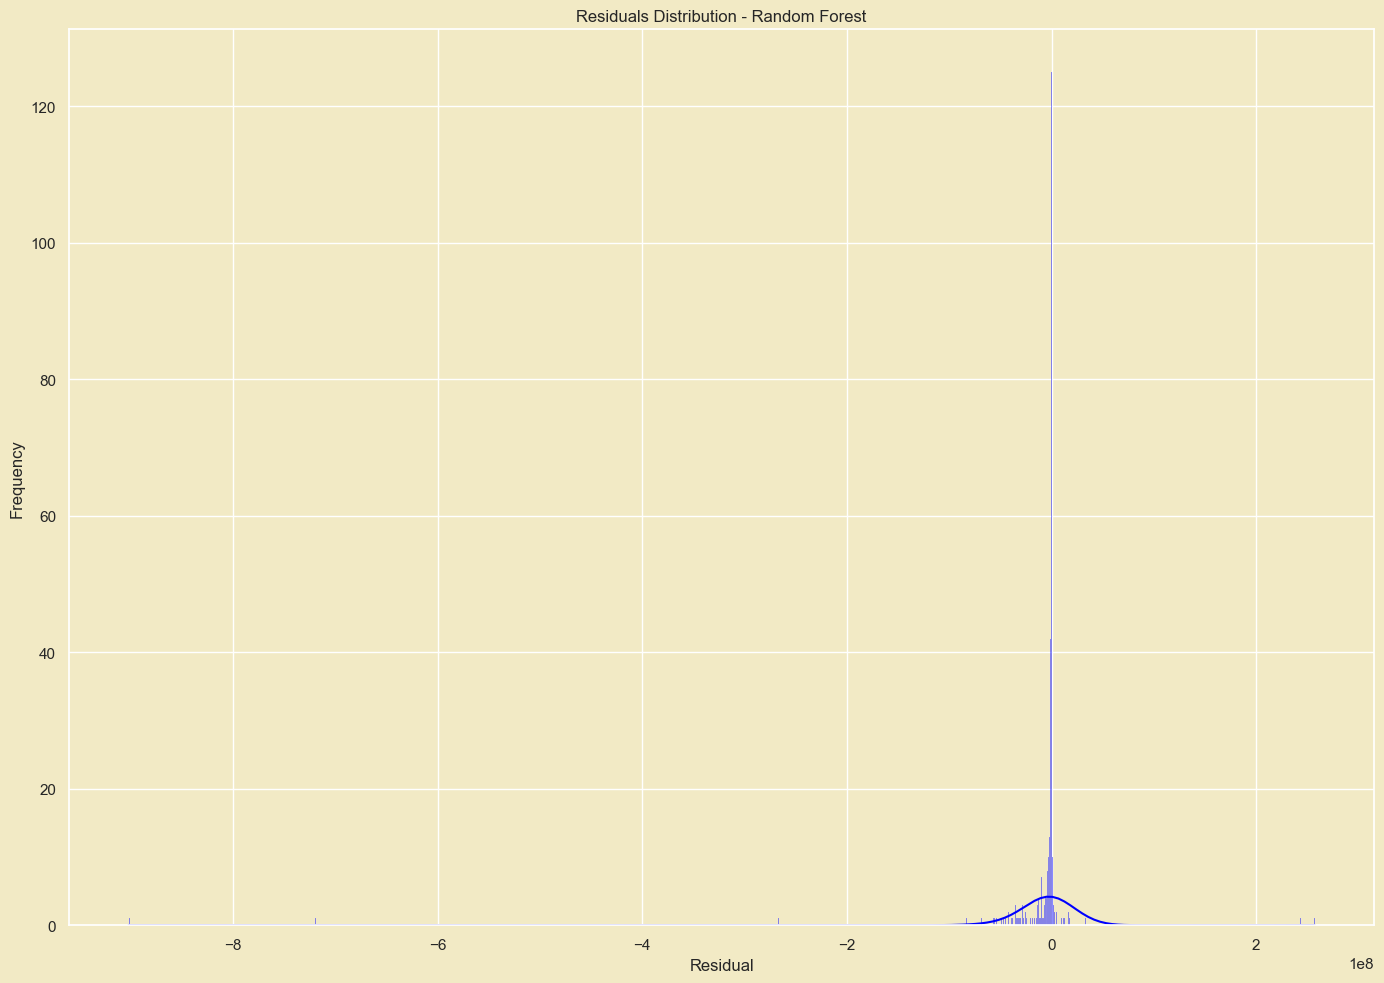

In [71]:
# 4. Residual Plots
# Random Forest Residuals
rf_residuals = y_test - rf_predictions
plt.figure(figsize=(14, 10))
sns.histplot(rf_residuals, kde=True, color='blue')
plt.title('Residuals Distribution - Random Forest')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

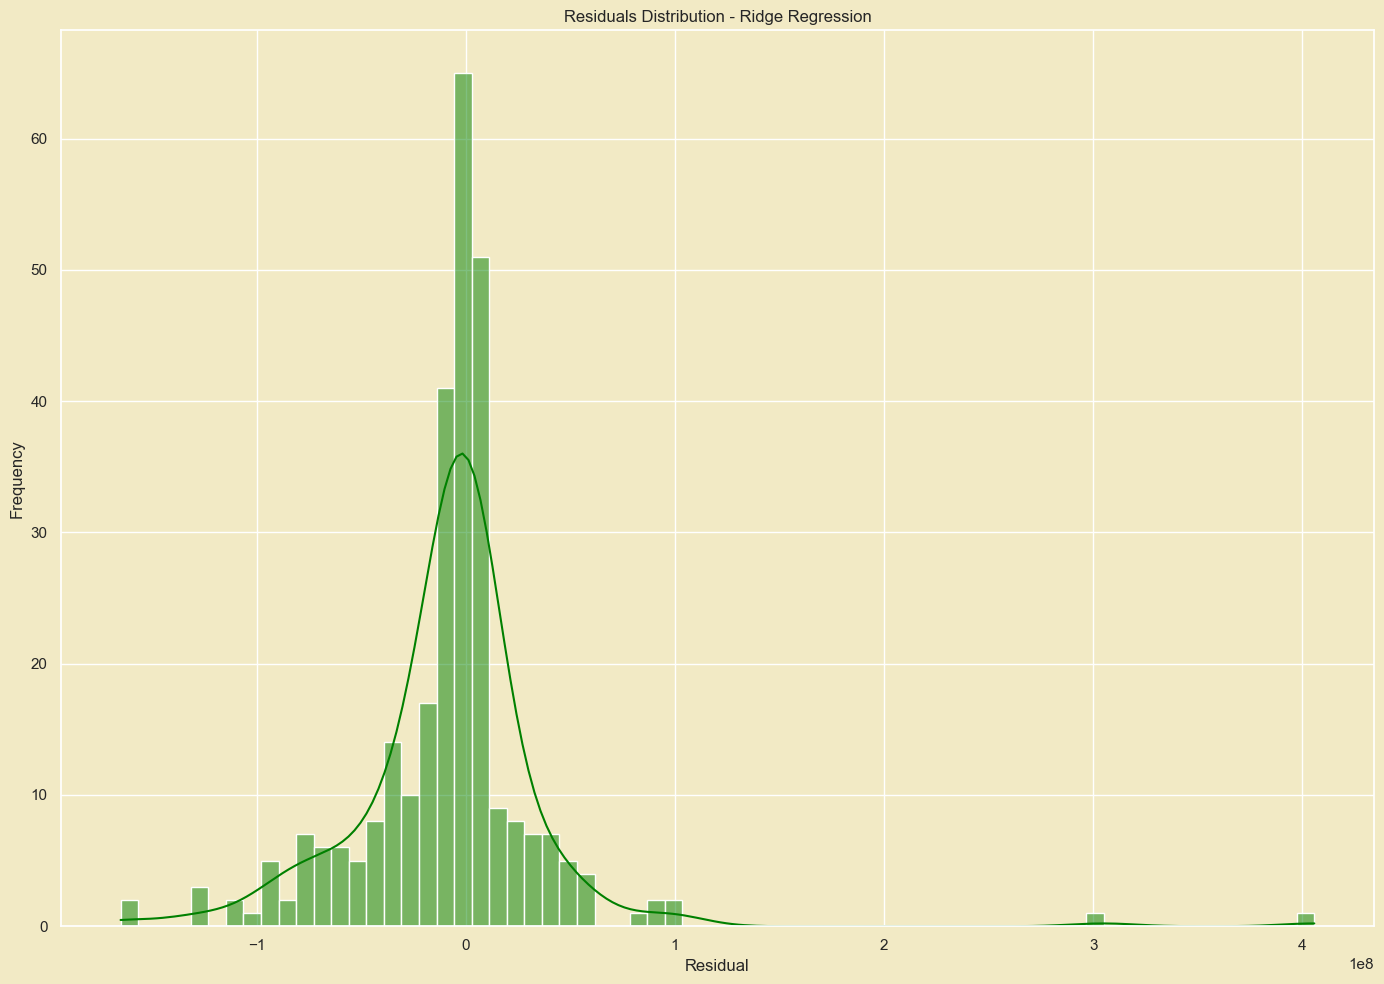

In [72]:
# Ridge Regression Residuals
ridge_residuals = y_test - ridge_predictions
plt.figure(figsize=(14, 10))
sns.histplot(ridge_residuals, kde=True, color='green')
plt.title('Residuals Distribution - Ridge Regression')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Actual vs. Predicted - Random Forest')

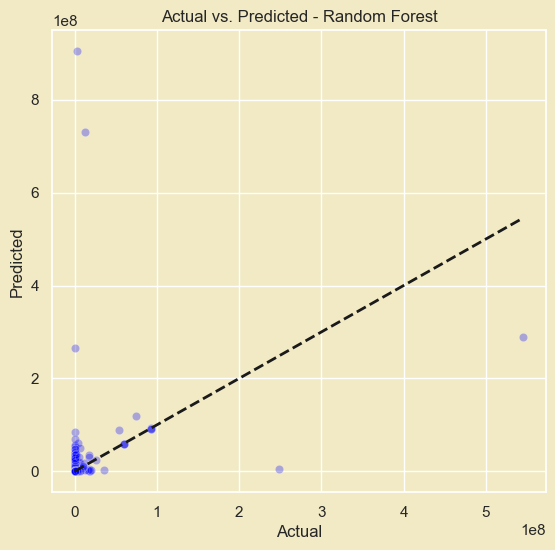

In [73]:
# 5. Actual vs. Predicted Scatter Plots
plt.figure(figsize=(14, 6))

# Random Forest
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=rf_predictions, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted - Random Forest')

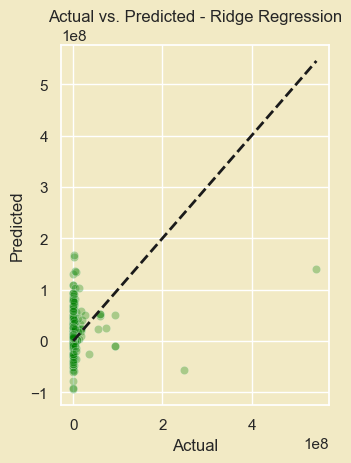

In [74]:
# Ridge Regression
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=ridge_predictions, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted - Ridge Regression')

plt.tight_layout()
plt.show()

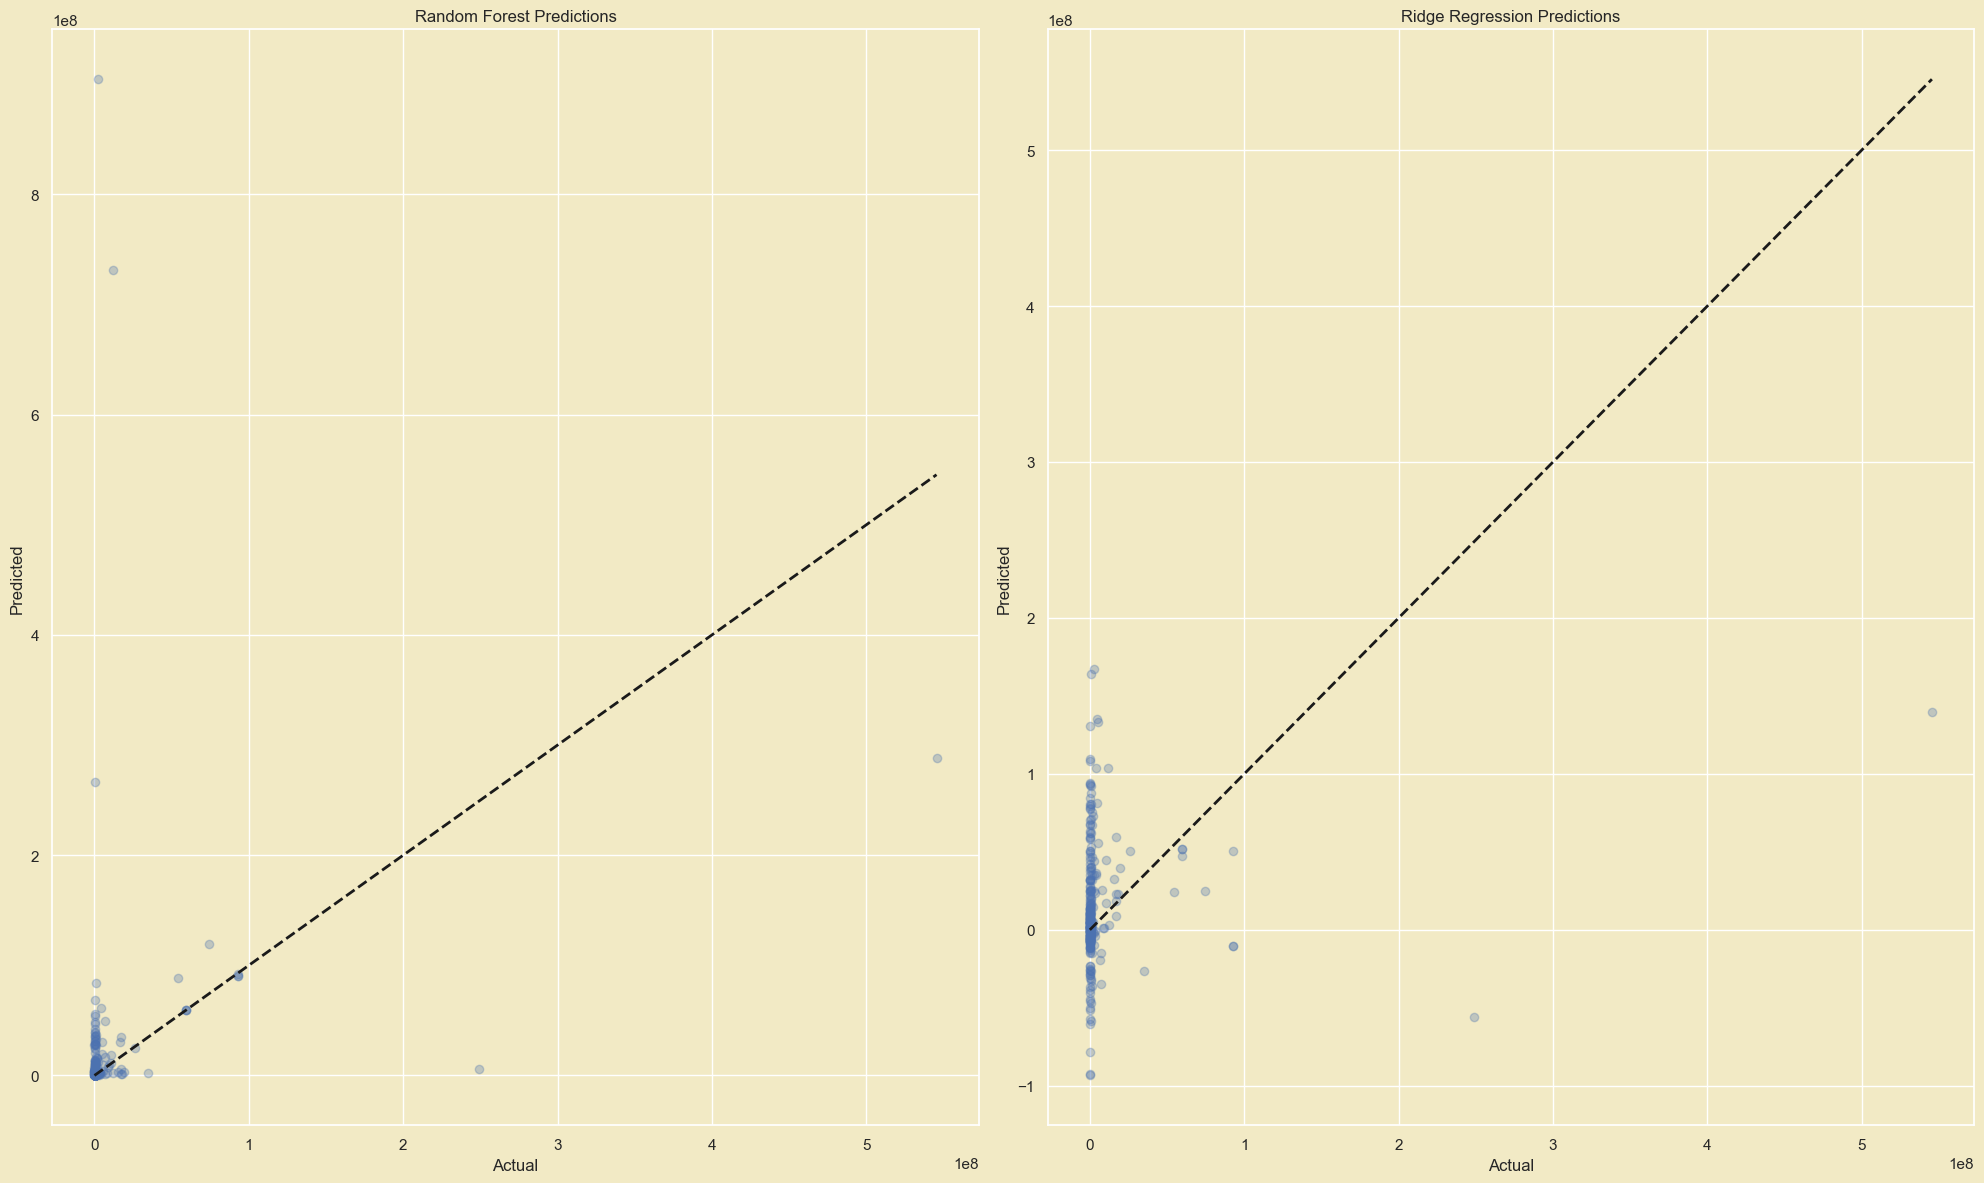

In [75]:
# Plot the results
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Predictions')

plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Ridge Regression Predictions')

plt.tight_layout()
plt.show()